<span style="color: blue; font-size: 16px;">Please, consider upvoting my notebook if you find it useful.</span>

<div style="background-color: #e8ebe6; text-align: justify; width: 725px">
<h2 style="background-color: #cfd4d1; padding: 7px; width: 710px; font-size: 30px; text-align: center; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.15), 0 6px 20px 0 rgba(0, 0, 0, 0.15); border-radius: 10px;">Objective of the Notebook</h2>
<span style="font-size: 20px; margin-bottom: 5px; color: blue; font-weight: bold;">Problem Statement</span>
<p style="font-size: 16px;">
    You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.
</p>
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*UDi7KpyFX8gwV1k7aeMS-g.jpeg">
</div>

In [1]:
from zipfile import ZipFile
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import string
from sklearn.model_selection import train_test_split
import os
import statistics
import shutil
import matplotlib
import re
import warnings
from catboost import CatBoostClassifier, cv
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.printoptions(pricision=2)
import pandas as pd
import itertools
pd.set_option('display.max_columns', 30)
# %matplotlib inline
warnings.filterwarnings('ignore')
# nltk.download('stopwords')
plt.style.use('ggplot')
from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox, skew, kurtosis, normaltest
from sklearn.decomposition import PCA
import sklearn.impute
from catboost import Pool
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dtypes = dict(
    Month="category",
    Name="category",
    Occupation="category",
    Type_of_Loan="category",
    Credit_History_Age="category",
    Payment_Behaviour="category"
)


train_df = pd.read_csv("../train.csv", dtype=dtypes, parse_dates=['Month'])
train_df["is_train"] = True
test_df = pd.read_csv("../test.csv", dtype=dtypes, parse_dates=['Month'])
test_df["is_train"] = False
df = pd.concat([train_df, test_df])

In [3]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,is_train
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,True
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,True
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,True
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,True
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,True


In [4]:
np.unique(df["Credit_Mix"])

array(['Bad', 'Good', 'Standard', '_'], dtype=object)

In [5]:
df.drop(["Name", "SSN", "ID"], axis=1, inplace=True, errors="ignore") # Dropping irrelevant columns

# Looking for unique values in categorical columns
This code extracts and analyzes categorical columns in a DataFrame, recording statistics about their unique values, counts, and percentages of occurrence, and returns this information in a structured DataFrame.

In [6]:
def get_unique_values(df):
    cat_cols = df.select_dtypes("object").columns

    data_info = np.zeros((len(cat_cols), 5), dtype="object")
    for i, col in enumerate(cat_cols):
        if len(df[col].unique()) > 5000:
            continue
        else:
            unique_values, counts = np.unique(
                np.array(df[col], dtype=str), return_counts=True)
            num_of_uv = len(unique_values)
            unique_val_percent = np.round(counts / counts.sum(), 2)
            data_info[i, :] = [col, unique_values.tolist(
            ), counts.tolist(), num_of_uv, unique_val_percent]
    return pd.DataFrame(data_info, columns=["column", "unique", "counts", "len_unique_values", "%_unique_values"])

In [7]:
unique_values_df = get_unique_values(df)
unique_values_df.head()

,column,unique,counts,len_unique_values,%_unique_values
0,0,0,0,0,0
1,Month,"[April, August, December, February, January, J...","[12500, 12500, 12500, 12500, 12500, 12500, 125...",12,"[0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.0..."
2,Age,"[-500, 100, 1004, 1006, 1007, 1010, 1018_, 102...","[1350, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2524,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0,0,0,0
4,Num_of_Loan,"[-100, 0, 0_, 1, 100, 1001, 1002, 1006, 1008, ...","[5850, 15543, 833, 15112, 1, 1, 1, 1, 1, 1, 1,...",623,"[0.04, 0.1, 0.01, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0..."


## Data Processing with the DataProcessor Class

This Python code defines a versatile `DataProcessor` class for efficiently preprocessing and cleaning data within a DataFrame. The class includes several methods, each designed to perform specific data cleaning and transformation tasks:

- **`get_month`**: This method extracts and calculates months from date-like strings found in the data.

- **`get_numbers`**: A static method that extracts numerical values from text strings, useful for cleaning columns containing mixed data.

- **`replace_special_character`**: Another static method that replaces special characters and handles specific cases like "NM" and "payments."

- **`preprocess_text`**: This static method tokenizes and processes text data, creating a dictionary of unique tokens and returning cleaned, tokenized strings.

- **`fill_na`**: This method fills missing values in categorical and numerical columns based on a specified grouping.

- **`preprocess`**: The main preprocessing method of the class. It applies a series of transformations to the DataFrame, such as extracting numbers from the 'Age' column, applying the `replace_special_character` function to the entire DataFrame, handling 'Credit_Mix' and 'Payment_Behaviour' columns, tokenizing 'Type_of_Loan' values, converting 'Credit_History_Age' values, and handling missing values with the `fill_na` method.

By using the `DataProcessor` class, you can efficiently prepare your data for analysis or modeling tasks, ensuring that it's clean, structured, and ready for further exploration. The class provides reusable methods for common data preprocessing challenges, making it a valuable tool in your data analysis workflow.


In [8]:
class DataProcessor:

    def __init__(self, groupby, data_frame):
        self.groupby = groupby
        self.df = data_frame


    def get_month(self, x):
     if not pd.isnull(x):
         year_month = re.findall(r"\d+", x)
         months = (int(year_month[0])*12) + np.int64(year_month[-1])
         return months
     else:
         x

    @staticmethod
    def get_numbers(text):
        digits = re.findall(r'\d+', str(text))
        digits = ','.join(digits)
        return digits

    @staticmethod
    def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        return np.nan if clean_text == "nan" else clean_text

    @staticmethod
    def preprocess_text(texts:str) -> tuple[dict, list[list[str]]]:
        dictionary = {}

        tokens = [str(text).lower().replace("and", "").split(",") for text in texts]
        tokens = [[token.strip() for token in token_list if token not in string.punctuation] for token_list in tokens]
        for token_list in tokens:
            for token in token_list:
                if token not in dictionary:
                    size = len(dictionary)
                    dictionary[token] = size
        return (dictionary, ["|".join(words) for words in tokens])


    @staticmethod
    def fill_na(df: pd.DataFrame, groupby=None):
        cat_features = df.select_dtypes(exclude="number").columns.drop(
            ["is_train", "Credit_Score", "Type_of_Loan"])
        num_features = df.select_dtypes(include="number").columns

        df["Type_of_Loan"].fillna("not specified", inplace=True)

        def fill_na_cat(df):
            df[cat_features] = df.groupby(groupby)[cat_features].transform(
                lambda x: x.fillna(x.mode()[0]))
            return df

        def fill_na_num(df):
            df[num_features] = df.groupby(groupby)[num_features].transform(
                lambda x: x.fillna(x.median()))
            return df

        df = fill_na_cat(df)
        df = fill_na_num(df)
        return df


    def preprocess(self):
        self.df['Age'] = self.df.Age.apply(DataProcessor.get_numbers)
        self.df = self.df.applymap(DataProcessor.replace_special_character)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        self.df["Credit_Mix"] = self.df.groupby(self.groupby)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        self.df["Payment_Behaviour"] = self.df.groupby(self.groupby)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8" if x.mode()[0] != "@9#%8" else np.nan)
        )
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x:  DataProcessor.preprocess_text(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ")
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.get_month(x))
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        self.df = DataProcessor.fill_na(self.df, "Customer_ID")

        return self.df

In [9]:
preprocesor = DataProcessor("Customer_ID", df)
data = preprocesor.preprocess()

In [10]:
data.loc[df["Num_Bank_Accounts"]<0, "Num_Bank_Accounts"] = 0  # Replacing account balances less than zero with zero
data.loc[data["Type_of_Loan"]=="nan", "Type_of_Loan"] = np.nan  #Replace "nan" values in the 'Type_of_Loan' column with NaN for consistency
data.loc[data["Occupation"] == "", "Occupation"] = np.nan  #Replace "nan" values in the 'Occupation' column with NaN for consistency
data.loc[data["Credit_Mix"] == "", "Credit_Mix"] = np.nan  #Replace "nan" values in the 'Credit_Mix' column with NaN for consistency

## Custom Outlier Removal and Skewness Correction

The provided Python code defines a `ClipOutliersTransformer` class and functions for outlier removal and skewness correction within a pandas DataFrame.

- **`ClipOutliersTransformer` Class**: This class is designed to transform numerical data by clipping outliers. It takes parameters such as lower and upper quantiles, a multiplier for defining the clipping limits, and an option to replace outliers with the median. The `fit` method calculates the lower and upper clipping limits based on quantiles, and the `transform` method applies the clipping transformation.

- **`get_skewness` Function**: This function calculates the skewness of numerical columns in a DataFrame and categorizes them as highly skewed or lowly skewed based on user-defined skewness thresholds.

- **`remove_outliers` Function**: This function is used to remove outliers and correct skewness in numerical columns of a DataFrame. It first identifies highly and lowly skewed columns using the `get_skewness` function. Then, it applies the `ClipOutliersTransformer` to clip outliers in highly skewed columns while replacing them with the median, and to clip outliers in lowly skewed columns without replacement.

These tools collectively provide a flexible and customizable approach to handling outliers and skewness in your dataset, allowing for improved data quality and more accurate analysis or modeling.


In [11]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        # self.feature_names_in_ = X.columns.tolist()

        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame):
    category = df.select_dtypes(exclude="number").columns.drop(
        ["Credit_Score"])
    numbers = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numbers],
                                               lower=-0.8,
                                               upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [12]:
data = remove_outliers(data)

In [13]:
def make_boxplot(df, column, ax):
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, palette="Set2")
    plt.xticks(rotation=90)
    # add the five number summary to the plot
    plt.title(column, fontdict={"fontsize": 10})
    plt.xticks(rotation=0)

In [14]:
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

In [15]:
def plot_boxplot_num_cols(df):
    fig = plt.figure(figsize=(18, 14), dpi=300)
    numb_columns = df.select_dtypes(include="number").columns
    for column in numb_columns:
        ax = fig.add_subplot(5, 4, list(numb_columns).index(column)+1)
        make_boxplot(df, column, ax)
        plt.tight_layout(pad=0.3)
    plt.tight_layout()
    plt.show()

## Data Visualization with Box Plots and Intuition

The provided Python code defines functions for creating box plots, which are a powerful visualization tool for understanding the distribution of numerical data. 

- **Box Plots Intuition**: Box plots provide a graphical representation of the data's central tendency, spread, and potential outliers. The "box" in the plot represents the interquartile range (IQR), which encompasses the middle 50% of the data. The line inside the box denotes the median (50th percentile), while the "whiskers" extend to the minimum and maximum values within a defined range or to the nearest data points within a certain distance from the quartiles. Any data points outside the whiskers are considered outliers and are plotted individually.

- **`make_boxplot` Function**: This function creates a box plot for a specified numerical column against the 'Credit_Score' column in the DataFrame. It allows us to visually assess how the values of a particular numerical variable are distributed within different credit score groups.

- **`plot_boxplot_num_cols` Function**: This function automates the creation of multiple box plots for all numerical columns in the DataFrame, making it easier to compare the distributions of various numerical features.

By using box plots, you can quickly identify potential outliers, assess the central tendency and spread of data, and gain insights into the overall distribution of numerical variables, aiding in data exploration and decision-making in data analysis and modeling.


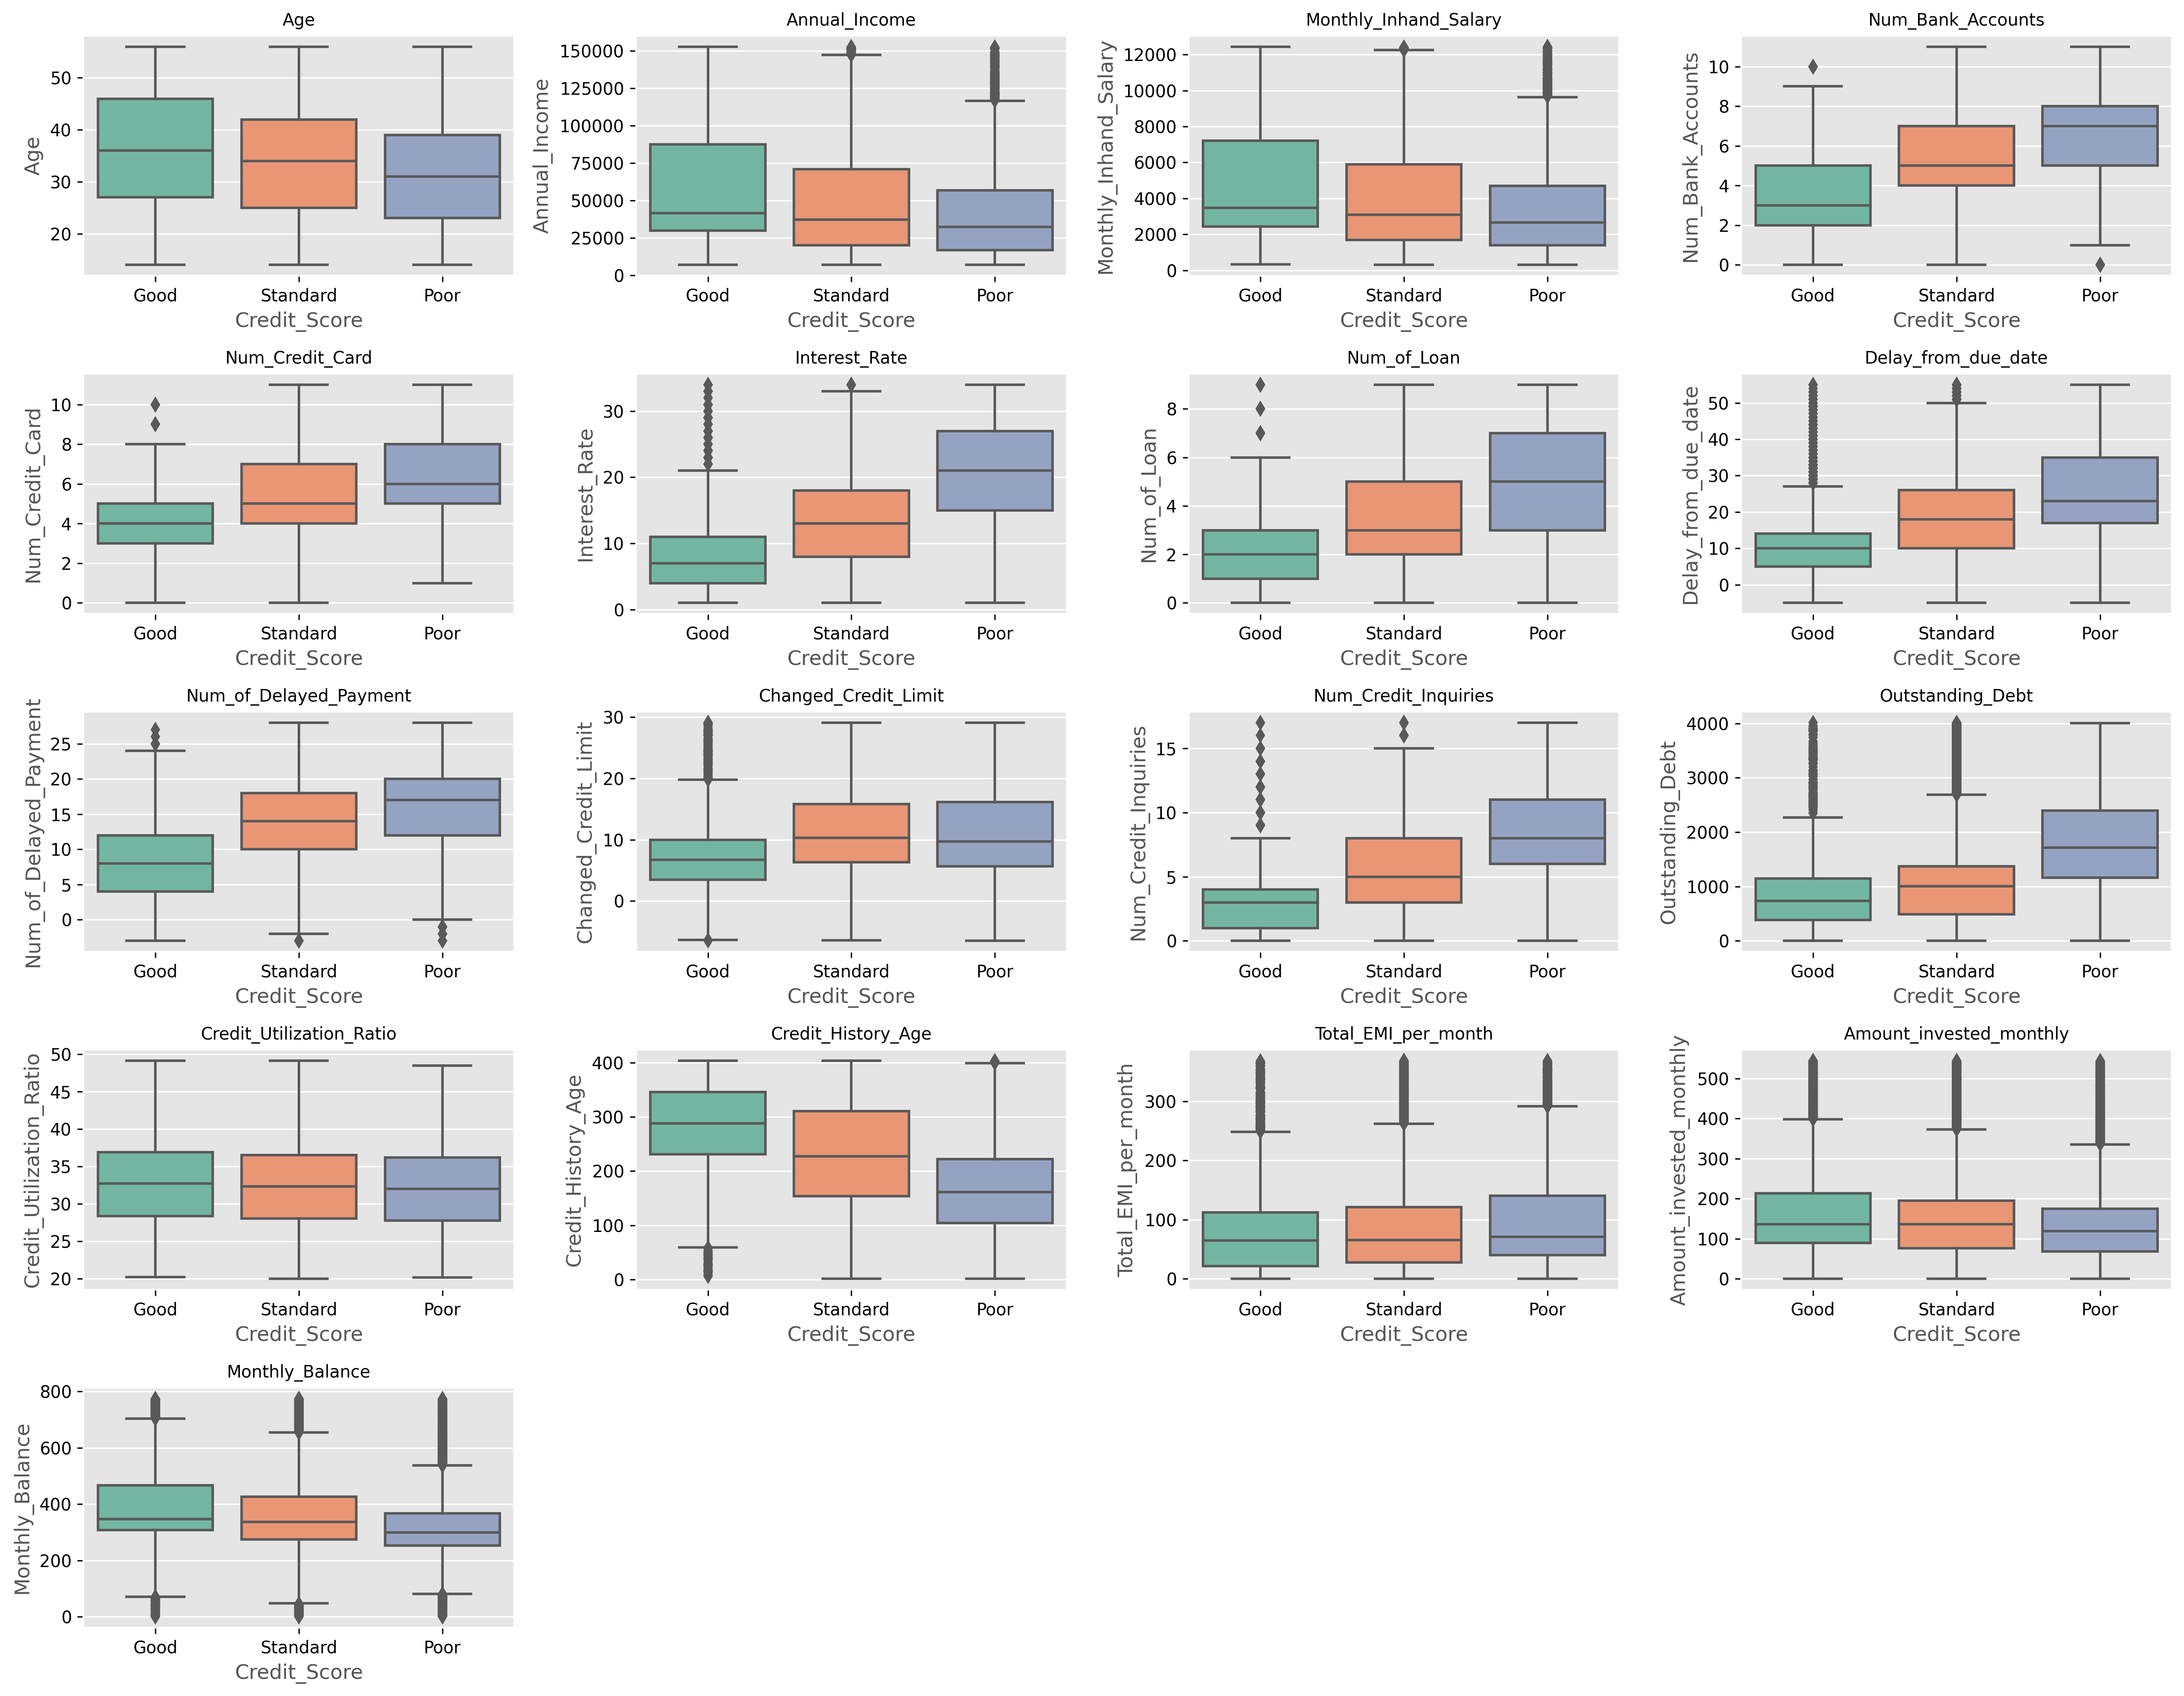

In [16]:
plot_boxplot_num_cols(data)

<Axes: xlabel='Credit_Mix', ylabel='count'>

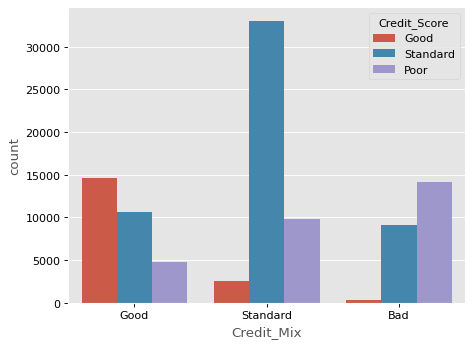

In [17]:
sns.countplot(data=data, x="Credit_Mix", hue="Credit_Score")

In [18]:
data.to_csv("clean_data_credit.csv", index=False)

In [19]:
import os
"clean_data_credit.csv" in os.listdir()

True

In [20]:
df = pd.read_csv("clean_data_credit.csv")

In [21]:
df_copy = data.copy()
df_copy["Monthly_Balance"] = df_copy.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: np.where((x>np.quantile(x, 0.75)) | x<np.quantile(x, 0.75), np.median(x), x))

In [22]:
cross_tab = pd.crosstab(values=df_copy["Monthly_Balance"], index=[
                        df_copy["Credit_Score"], df_copy["Credit_Mix"]], columns="Monthly_Balance", aggfunc="mean").reset_index()

main_group = pd.pivot_table(cross_tab, "Monthly_Balance", "Credit_Score", aggfunc=np.mean)
cross_tab

col_0,Credit_Score,Credit_Mix,Monthly_Balance
0,Good,Bad,296.320348
1,Good,Good,403.335501
2,Good,Standard,387.642526
3,Poor,Bad,300.345681
4,Poor,Good,401.109600
5,Poor,Standard,343.470179
6,Standard,Bad,290.381714
7,Standard,Good,397.612596
8,Standard,Standard,387.203665


In [23]:
b = plt.cm.Blues
a = plt.cm.Accent
# k = plt.cm.Blues(100, 0.9)

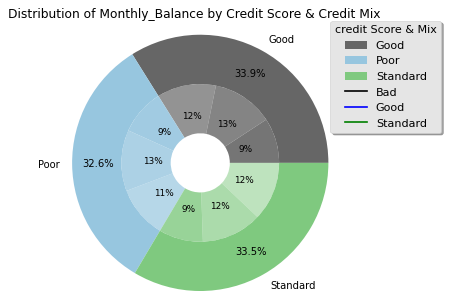

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Distribution of Monthly_Balance by Credit Score & Credit Mix",
             fontsize=11,
             color="k")
# fig.patch.set_alpha(0)
# fig.patch.set_facecolor("#ff9999")
fig.set_frameon(True)

pie1, *_, texts = ax.pie(x=main_group["Monthly_Balance"],
                         labels=main_group.index,
                         autopct="%.1f%%",
                         radius=1.3,
                         colors=[a(80, 1), b(100, 1),
                                 a(0, 1)],
                         pctdistance=0.8,
                         textprops={"size": 9},
                         frame=True)
plt.setp(pie1, width=0.5)
ax.set_frame_on(True)

pie2, *_, texts = ax.pie(x=cross_tab["Monthly_Balance"],
                         autopct="%.0f%%",
                         radius=0.8,
                         colors=[
                             a(80, 0.9),
                             a(80, 0.8),
                             a(80, 0.7),
                             b(100, 0.9),
                             b(100, 0.8),
                             b(100, 0.7),
                             a(0, 0.8),
                             a(0, 0.65),
                             a(0, 0.5)
],
    textprops={"size": 8})
plt.setp(pie2, width=0.5)
legend_labels = np.unique(cross_tab["Credit_Mix"])

legend_handles = [
    plt.plot([], label=legend_labels[0], c="k"),
    plt.plot([], label=legend_labels[1], c='b'),
    plt.plot([], label=legend_labels[-1], c="g")
]
plt.legend(shadow=True,
           frameon=True,
           facecolor="inherit",
           loc="best",
           title="credit Score & Mix",
           bbox_to_anchor=(1, 1, 0.5, 0.1))

plt.show()


In [25]:
def make_countplot(df: pd.DataFrame):

    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score', 'is_train', 'Customer_ID', "Type_of_Loan"])
    cat_cols = list(cat_cols)
    cat_cols.pop(-1)
    cat_cols.insert(-2, "Payment_Behaviour")

    fig, axes = plt.subplots(figsize=(12, 6), dpi=300)
    fig.suptitle("Counts of categorical columns")
    axes.grid(visible=False)
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.set_tick_params(labelleft=False)

    def __plot_graph(df, col, ax: plt.Axes, legend=False):
        sns.countplot(
            data=df,
            x=col,
            ax=ax,
            hue="Credit_Score",
        )
        # label =ax.get_xlabel()
        ax.set_xlabel(col, fontdict={"size": 9})
        ax.set_title(f"by {col}", fontdict={"size": 9})
        ax.get_xticklabels()
        ax.tick_params(labelsize=7, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=90,
                           fontdict=dict(size=7))
        ax.grid(False)
        if legend:
            ax.legend(shadow=True,
                      loc="best",
                      facecolor="inherit",
                      frameon=True)
        else:
            ax.legend_ = None
        plt.tight_layout(w_pad=1)

    for i, col in enumerate(cat_cols, 1):
        if i == 3:
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, legend=True)
    plt.show(True)

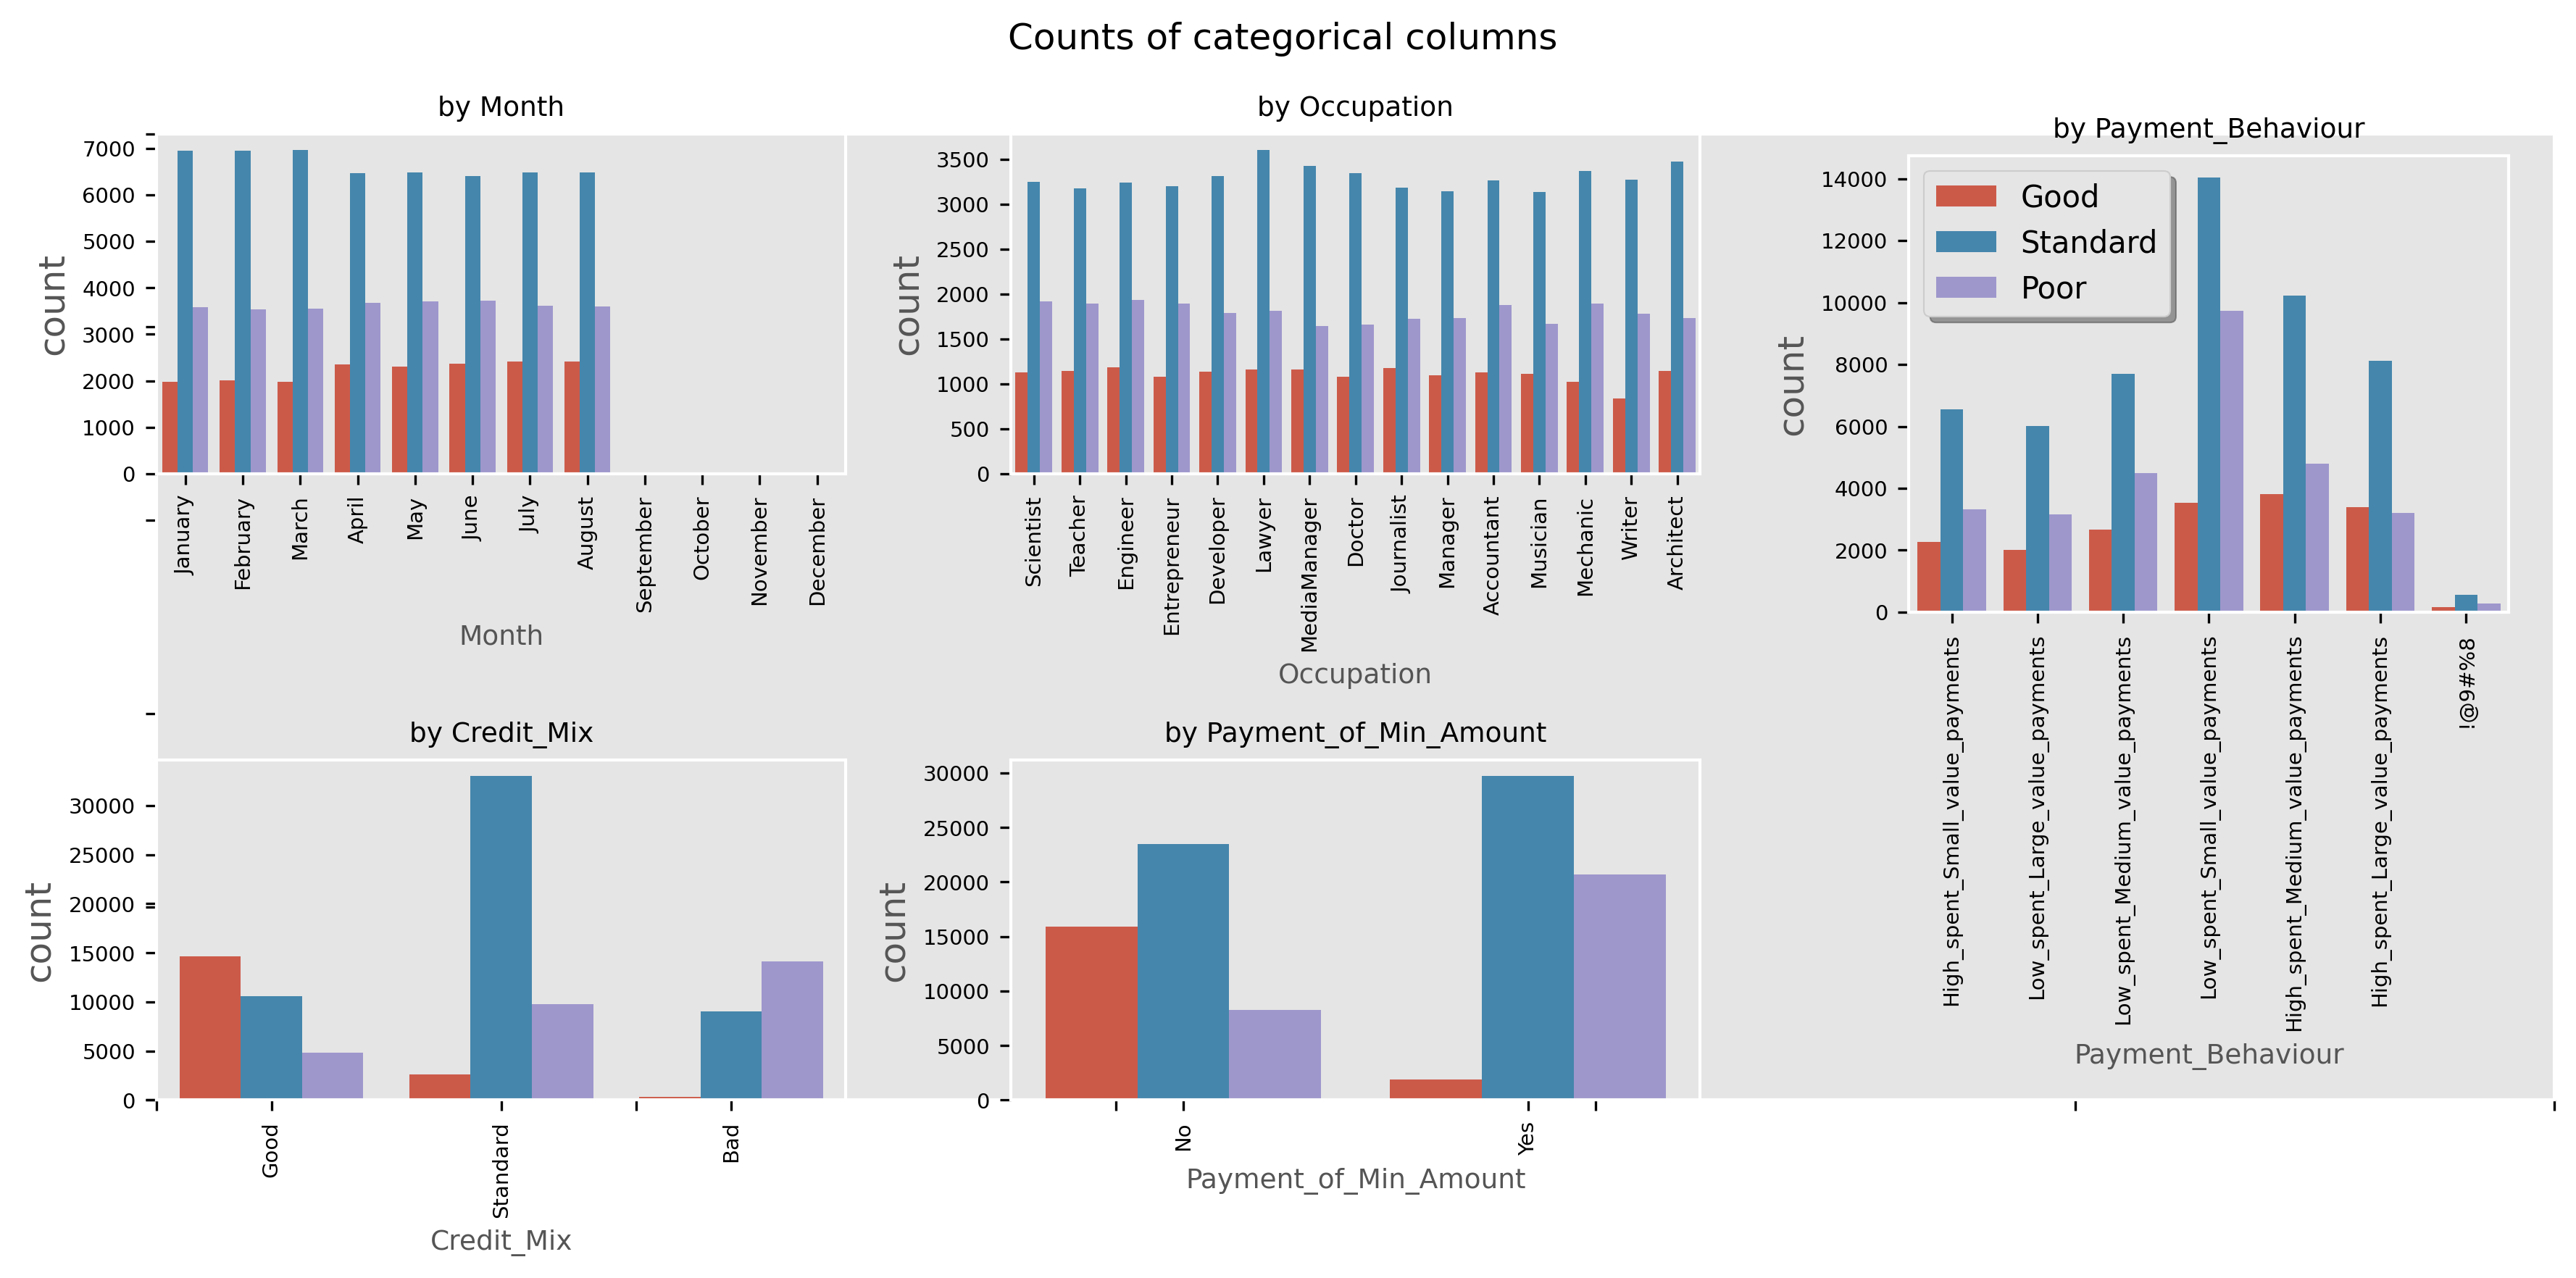

In [26]:
make_countplot(df)

## Correlation Heatmap and Intuition

The provided Python code calculates and visualizes the correlation matrix of numerical features in the dataset, excluding the "is_train" column. Here's the intuition behind the code:

- **Correlation Matrix**: The code computes a correlation matrix (`corr`) that quantifies the linear relationships between pairs of numerical features. Each cell in the matrix represents the correlation coefficient, which can range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

- **Masking the Upper Triangle**: To enhance clarity, the code applies a mask (`mask`) to hide the upper triangular part of the matrix. This is because the correlation matrix is symmetric, and the upper triangle contains redundant information.

- **Heatmap Visualization**: The `sns.heatmap` function from the Seaborn library is used to create a heatmap of the correlation matrix. Annotations in the heatmap display the correlation coefficients as percentages. The resulting visualization provides a quick overview of how numerical features relate to each other, helping identify strong correlations (either positive or negative) and potential multicollinearity in the data.

- **Intuition**: By examining the heatmap, you can gain insights into which pairs of features are highly correlated. Positive correlations suggest that when one feature increases, the other tends to increase as well, while negative correlations indicate an inverse relationship. Understanding these relationships can inform feature selection, identify redundant features, and guide feature engineering during data analysis or modeling.


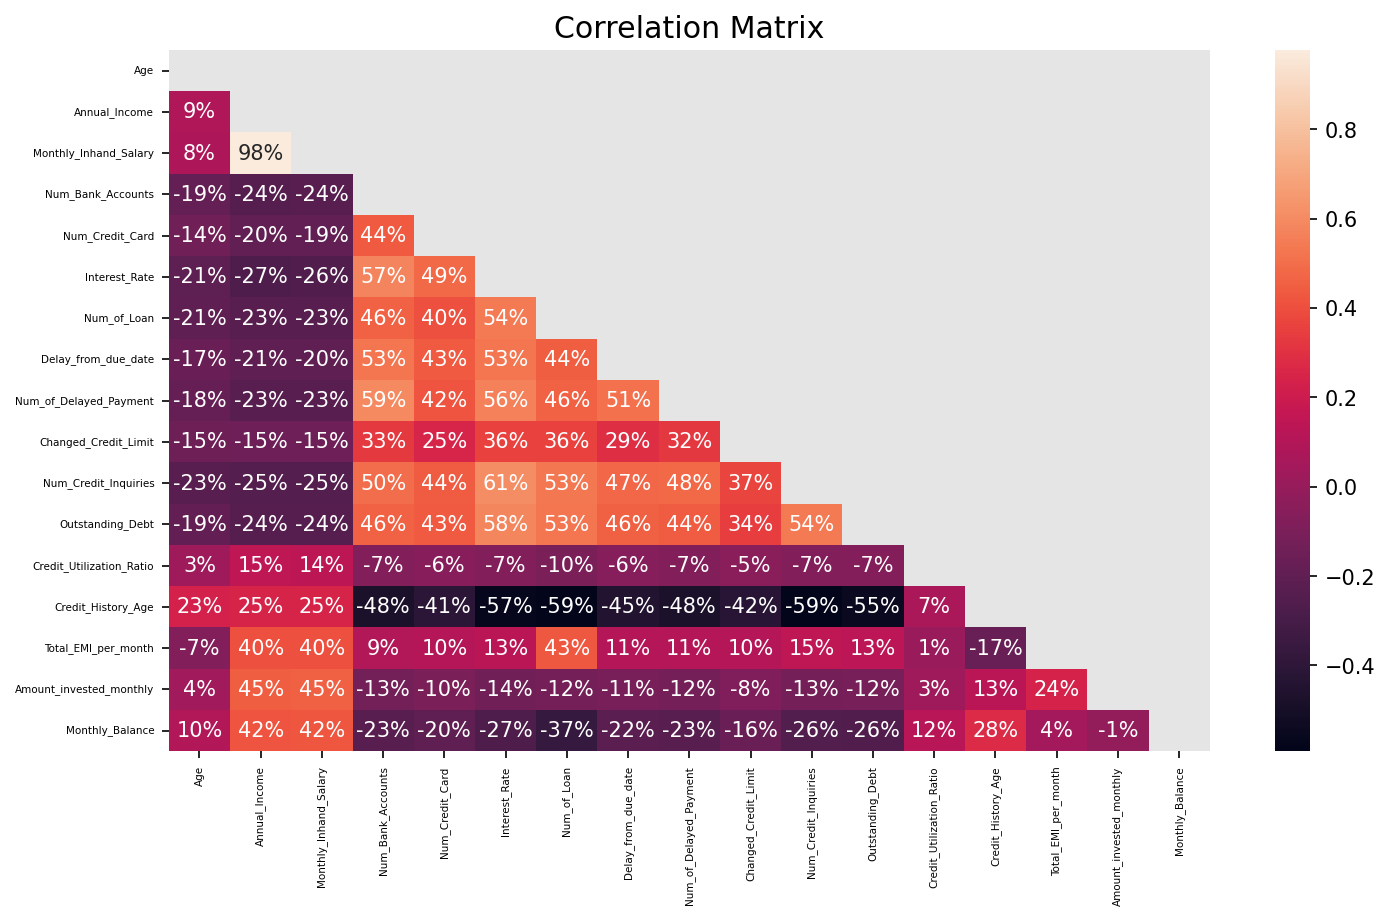

In [27]:
corr = data.drop(["is_train"], axis=1).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 6), dpi=150)

sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
plt.grid(False)
plt.tick_params(axis="both", labelsize=5)
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

In [28]:
df.loc[~df["is_train"], "Month"].value_counts()

Month
September    12500
October      12500
November     12500
December     12500
Name: count, dtype: int64

## Hypothesis Testing with Chi-Square and F-Tests

This Python code defines a `chi_2_test` function that conducts hypothesis testing to assess the relationship between categorical and numerical columns in a DataFrame and the target variable 'Credit_Score.'

- **Function Purpose**: The `chi_2_test` function first prepares a copy of the DataFrame with only training data and selects categorical and numerical columns of interest. It then initializes an empty NumPy array to store test results. The function performs two types of tests: Chi-Square tests for categorical columns and F-tests (ANOVA) for numerical columns to assess their significance in explaining 'Credit_Score' variations.

- **Hypothesis Testing**: The Chi-Square test evaluates the independence between categorical variables and 'Credit_Score,' while the F-tests assess the variance in 'Credit_Score' explained by numerical variables. The results include the test statistic and p-value for each column, helping identify significant factors influencing 'Credit_Score.'

This function provides valuable insights into how different features relate to 'Credit_Score,' aiding in feature selection and understanding the dataset's predictive power in credit scoring analysis or modeling.


In [29]:
def chi_2_test(df:pd.DataFrame):
    df_copy = df.loc[df["is_train"]].copy()
    cat_cols = df_copy.select_dtypes(exclude="number").columns.drop(["Customer_ID", "Month", "is_train", "Credit_Score"])
    numb_columns = df_copy.select_dtypes(include="number").columns

    summary = np.empty((len(cat_cols)+len(numb_columns), 3), dtype="object")
    y, *_ = df_copy["Credit_Score"].factorize(sort=False)

    def perform_test(*args, test):

        if test == "chi2":
            for i, col in enumerate(args[0]):
                cross = pd.crosstab(index=df[col], columns=[df["Credit_Score"]])
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue]

        elif test=="f_classif":
            for i, col in enumerate(args[0], start=len(summary)-len(args[0])):
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]

    perform_test(cat_cols, test="chi2")
    perform_test(numb_columns, test="f_classif")

    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

In [30]:
chi2_summary = chi_2_test(data).sort_values(by="t-statistic", ascending=False)

In [31]:
chi2_summary.style.bar("t-statistic").background_gradient(
    "Blues", subset="t-statistic")

,column,t-statistic,p-value
1,Type_of_Loan,65283.448081,0.000000
2,Credit_Mix,39939.333264,0.000000
3,Payment_of_Min_Amount,16869.960993,0.000000
10,Interest_Rate,14942.672179,0.000000
15,Num_Credit_Inquiries,11640.610032,0.000000
16,Outstanding_Debt,10172.739505,0.000000
12,Delay_from_due_date,9775.596949,0.000000
9,Num_Credit_Card,9472.156733,0.000000
8,Num_Bank_Accounts,9148.775200,0.000000
18,Credit_History_Age,8902.256599,0.000000


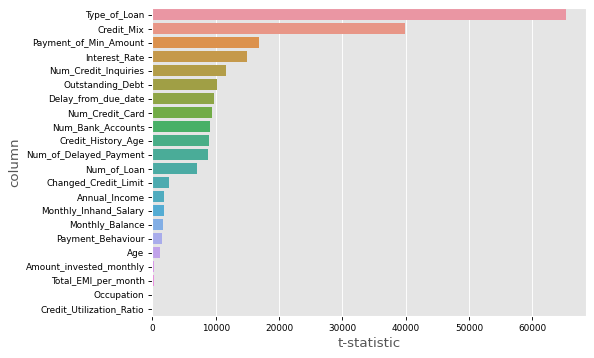

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

In [33]:
def transform_columns(data_frame: pd.DataFrame):
    category = data_frame.select_dtypes(exclude="number").columns.tolist()
    number =data_frame.select_dtypes(include="number").columns.tolist()


    def build_pipeline_numb(strategy="median"):
        pipe1 = Pipeline(steps=[
            ("imputer", IterativeImputer(initial_strategy=strategy, random_state=42)),
            ("scaling", MinMaxScaler()),
            # ("pca", PCA(0.98))
            # ("scaling", PowerTransformer())

        ])
        return pipe1

    def build_pipeline_cat(strategy="most_frequent"):
        pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=strategy))
])
        return pipe2

    transformer = ColumnTransformer(
        [
            ("cat_transformer", build_pipeline_cat(), category),
            ("numb_transformer", build_pipeline_numb(), number)
        ],
        remainder="drop"
    )
    transformer.fit(data_frame)
    return transformer

## Data Transformation with Custom Pipelines

This Python code defines a data transformation function, `transform_columns`, which utilizes custom pipelines for preprocessing categorical and numerical columns in a DataFrame.

- **Column Selection**: The function first identifies categorical and numerical columns within the DataFrame, categorizing them into two separate lists.

- **Custom Pipelines**: It then defines two custom pipelines using scikit-learn's `Pipeline` class: one for numerical columns and another for categorical columns. The numerical pipeline imputes missing values with the median using IterativeImputer and scales the features to a consistent range using MinMaxScaler. The categorical pipeline imputes missing values with the most frequent value using SimpleImputer.

- **ColumnTransformer**: The pipelines are integrated into a `ColumnTransformer` object that applies the defined transformations to their respective columns, while the "remainder" parameter specifies that any untransformed columns should be dropped.

This function provides a flexible and structured way to preprocess categorical and numerical data separately, preparing it for downstream analysis or modeling tasks. It allows for customization of imputation strategies and ensures consistent scaling for numerical features.


In [34]:
def split_data(data: pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    df_copy = data.copy()
    df_copy.drop(columns = ["Month", "Customer_ID"], inplace=True)
    df_copy["Delay_from_due_date"] = df_copy["Delay_from_due_date"].abs()

    train_set = df_copy[df_copy["is_train"]].drop(["is_train"], axis=1)
    test_set = df_copy[df_copy["is_train"] == False].drop(
        ["is_train", "Credit_Score"], axis=1).reset_index(drop=True)

    X = train_set.drop("Credit_Score", axis=1)
    y = train_set.pop("Credit_Score")

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2, shuffle=True)
    return ((Xtrain, Xtest, ytrain, ytest), test_set)


def combined_transformers(data, save_to_pickle=False):
    outlier_remover = ClipOutliersTransformer(0.25, 0.75, multiply_by=1.5, replace_with_median=False)
    outlier_remover.fit(data.select_dtypes("number"))
    transformer = transform_columns(data)
    if save_to_pickle:
        file1 = open("OutlierRemover.pkl", "wb")
        file2 = open("ColumnsTransformers.pkl", "wb")
        pickle.dump(outlier_remover, file1)
        pickle.dump(transformer, file2)
    return (outlier_remover, transformer)


def get_transformed_data(data, transformers_to_pkl=False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # transformer = kwargs.get("transformer")
    train_set, test_set = split_data(data)
    Xtrain, Xtest, ytrain, ytest = train_set
    _, transformer = combined_transformers(Xtrain, save_to_pickle=transformers_to_pkl)

    columns = list(itertools.chain.from_iterable([transformer[-1] for transformer in transformer.__dict__.get("transformers")]))
    Xtrain = pd.DataFrame(transformer.transform(Xtrain), columns=columns).apply(pd.to_numeric, errors="ignore")
    Xtest = pd.DataFrame(transformer.transform(Xtest), columns=columns).apply(pd.to_numeric, errors="ignore")
    test_set = pd.DataFrame(transformer.transform(test_set), columns=columns).apply(pd.to_numeric, errors="ignore")
    return ((Xtrain, Xtest), (ytrain, ytest), test_set)

In [35]:
((Xtrain, Xtest), (ytrain, ytest), test_set) = get_transformed_data(data, transformers_to_pkl=True)

cat_columns = Xtrain.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

## CatBoost Model Training Functions

These Python functions are designed for training CatBoost models efficiently in machine learning tasks:

- **`create_pool` Function**: This function prepares training and testing data by creating CatBoost Pools, which are optimized data structures for CatBoost models. It takes input features (`xtrain`, `ytrain`, `xtest`, `ytest`), categorical features (`cat_features`), and text features (`text_features`) as arguments and returns the corresponding CatBoost Pools for training and testing data.

- **`catboost_model` Function**: This function configures a CatBoostClassifier with default and custom parameters, such as the number of iterations, custom evaluation metrics, and multi-threading settings. Users can provide additional parameters to customize the model further.

- **`fit_model` Function**: The main training function that combines the previous two functions. It creates the data pools, configures the CatBoost model, fits the model to the training data while evaluating on the testing data, and allows for early stopping and additional keyword arguments.

These functions streamline the process of training CatBoost models, making it easier to handle data preparation, model configuration, and training with customizable options.


In [36]:
def create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features):
    Xtrain_pool = Pool(data=xtrain, label=ytrain, cat_features=cat_features, text_features=text_features)
    Xtest_pool = Pool(data=xtest, label=ytest, cat_features=cat_features, text_features=text_features)
    return (Xtrain_pool, Xtest_pool)


def catboost_model(params = {}):
    cb_params = {
        "iterations": 10000,
        "custom_metric": ["F1", "AUC", "Accuracy"],
        "thread_count":-1,
        "random_state": 42,
        "train_dir": "/catboost"
        
    }
    cb_params.update(params)

    model = CatBoostClassifier(**cb_params)
    return model


def fit_model(xtrain, ytrain, xtest, ytest, cat_features, text_features, params = {}, **kwargs):
    Xtrain_pool, Xtest_pool = create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features)
    model = catboost_model(params = params)
    model.fit(Xtrain_pool, eval_set=Xtest_pool, early_stopping_rounds=500, **kwargs)
    return model

## CatBoost Classifier Training

The provided Python code defines a function, `fit_catboost`, for training a CatBoost classifier on labeled data. This function takes training and testing data along with various parameters like categorical and text features, as well as optional custom parameters for the CatBoost model.

- **Data Preparation**: The function first creates CatBoost Pools for both the training and testing data, considering categorical and text features. These pools are optimized data structures that CatBoost uses for efficient training.

- **Model Configuration and Training**: It configures the CatBoostClassifier, including the number of iterations, custom metrics, and multithreading settings, and then fits the model to the training data while evaluating it on the testing data. The "early_stopping_rounds" parameter allows for early stopping to prevent overfitting.

- **Customization**: The function allows users to specify additional CatBoost parameters through the "params" argument and control the verbosity of training with the "verbose" argument. It also provides the option to visualize training progress with the "plot" parameter.

This function simplifies the process of training a CatBoost classifier, making it accessible for classification tasks while offering customization options for advanced users.


In [37]:
model = fit_model(
    Xtrain, ytrain,
    Xtest, ytest,
    cat_columns, text_column,
    plot=False,
    verbose=500,
    params = {
        "text_processing": ["NaiveBayes+Word|BoW+Word"],
        "task_type": "GPU",
        "one_hot_max_size": 3,
        "depth": 6,
        "auto_class_weights": "Balanced",
        "bootstrap_type": "Poisson",
        "subsample":0.5,
        "max_bin": 100
        
    }
)

Learning rate set to 0.059847


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.0576475	test: 1.0580528	best: 1.0580528 (0)	total: 8.12s	remaining: 22h 32m 45s
500:	learn: 0.5934872	test: 0.6323778	best: 0.6323778 (500)	total: 13.6s	remaining: 4m 17s
1000:	learn: 0.5324823	test: 0.5946400	best: 0.5946400 (1000)	total: 18.7s	remaining: 2m 48s
1500:	learn: 0.4891247	test: 0.5694946	best: 0.5694946 (1500)	total: 23.9s	remaining: 2m 15s
2000:	learn: 0.4540267	test: 0.5503833	best: 0.5503700 (1999)	total: 28.9s	remaining: 1m 55s
2500:	learn: 0.4253215	test: 0.5355064	best: 0.5355064 (2500)	total: 33.9s	remaining: 1m 41s
3000:	learn: 0.4016728	test: 0.5250324	best: 0.5250324 (3000)	total: 39s	remaining: 1m 30s
3500:	learn: 0.3810623	test: 0.5167864	best: 0.5167815 (3499)	total: 44.4s	remaining: 1m 22s
4000:	learn: 0.3627217	test: 0.5099797	best: 0.5099797 (4000)	total: 49.5s	remaining: 1m 14s
4500:	learn: 0.3460707	test: 0.5040530	best: 0.5040458 (4499)	total: 54.6s	remaining: 1m 6s
5000:	learn: 0.3312526	test: 0.4994404	best: 0.4994404 (5000)	total: 59.7s	r

In [38]:
import catboost

w = catboost.MetricVisualizer('/catboost/')
w.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
Xtrain_pool, Xtest_pool = create_pool(Xtrain, ytrain, Xtest, ytest, cat_columns, text_column)

In [40]:
importance = model.get_feature_importance(Xtest_pool, type="LossFunctionChange", prettified=True)

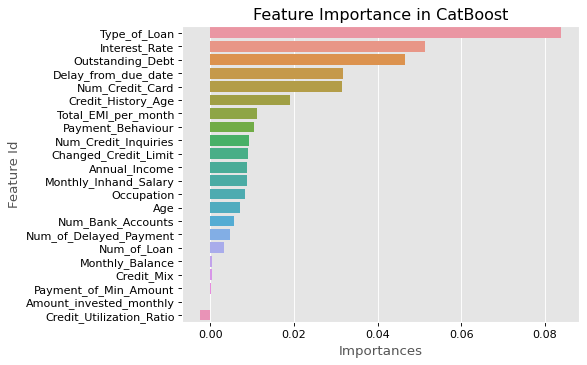

In [41]:
sns.barplot(data=importance, y="Feature Id", x = "Importances")
plt.title("Feature Importance in CatBoost")
plt.show()

## Model Refinement with Feature Selection

In this Python code snippet, feature selection and model refinement are performed for machine learning tasks.

- **Feature Selection**: It starts by creating a copy of the dataset (`df_copy`) with low-importance features removed using a condition based on feature importances. This preprocessing step helps focus on the most relevant features for modeling.

- **Data Transformation**: The data is then transformed using a function `get_transformed_data`, which prepares the training and testing sets along with specific transformers. This step ensures the data is ready for modeling.

- **Model Refinement**: A machine learning model is trained using the refined dataset (`Xtrain1`, `ytrain1`) and relevant categorical (`cat_columns`) and text (`text_column`) features. The model is fine-tuned with specific parameters, including text processing methods, task type (GPU), class weights, and maximum depth, enabling better predictive performance.

This code showcases a systematic approach to feature selection and model refinement, enhancing the effectiveness of machine learning models for predictive tasks.


In [42]:
df_copy = data.copy().drop(importance.query("Importances < 0.000")["Feature Id"], axis=1)
((Xtrain1, Xtest1), (ytrain1, ytest1), test_set) = get_transformed_data(df_copy, transformers_to_pkl=True)

cat_columns = Xtrain1.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

In [43]:
model_refined = fit_model(
    Xtrain1, ytrain1,
    Xtest1, ytest1,
    cat_columns, text_column,
    plot=False,
    verbose=500,
    params = {
        "text_processing": ["NaiveBayes+Word|BoW+Word"],
        "task_type": "GPU",
        "one_hot_max_size": 3,
        "auto_class_weights": "Balanced",
        "max_depth": 7,
        "bootstrap_type": "Poisson",
        "subsample":0.5,
        "max_bin": 100
    }
)

Learning rate set to 0.059847


Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.0568555	test: 1.0574100	best: 1.0574100 (0)	total: 23.1ms	remaining: 3m 51s
500:	learn: 0.5512689	test: 0.6039681	best: 0.6039681 (500)	total: 6.29s	remaining: 1m 59s
1000:	learn: 0.4733943	test: 0.5572325	best: 0.5572325 (1000)	total: 12.6s	remaining: 1m 53s
1500:	learn: 0.4206811	test: 0.5285679	best: 0.5285679 (1500)	total: 19s	remaining: 1m 47s
2000:	learn: 0.3819649	test: 0.5093472	best: 0.5093472 (2000)	total: 25.4s	remaining: 1m 41s
2500:	learn: 0.3521915	test: 0.4971679	best: 0.4971679 (2500)	total: 32.1s	remaining: 1m 36s
3000:	learn: 0.3270858	test: 0.4883655	best: 0.4883655 (3000)	total: 38.4s	remaining: 1m 29s
3500:	learn: 0.3051935	test: 0.4816566	best: 0.4816566 (3500)	total: 44.8s	remaining: 1m 23s
4000:	learn: 0.2862171	test: 0.4769279	best: 0.4768879 (3998)	total: 51s	remaining: 1m 16s
4500:	learn: 0.2697183	test: 0.4741809	best: 0.4741809 (4500)	total: 57.3s	remaining: 1m 9s
5000:	learn: 0.2551183	test: 0.4721461	best: 0.4721461 (5000)	total: 1m 3s	remaini

In [44]:
model_refined.save_model("credit_score_prediction_model-cb-v1")

# Model Evaluation

In [45]:
loaded_model = CatBoostClassifier()
loaded_model.load_model(r"credit_score_prediction_model-cb-v1")

Accuracy: 80.61%
F1 Score: {'Good': '77.28%', 'Poor': '81.95%', 'Standard': '81.10%'}
Precision Score: {'Good': '70.96%', 'Poor': '78.12%', 'Standard': '86.72%'}
Recall Score: {'Good': '84.83%', 'Poor': '86.19%', 'Standard': '76.15%'}



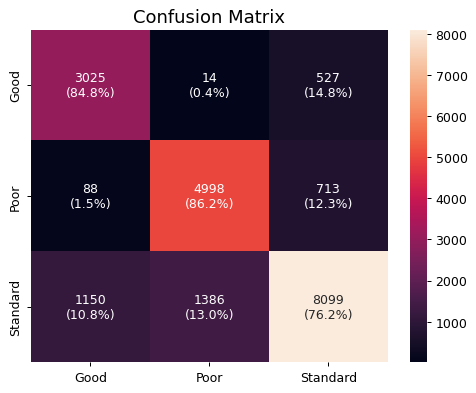

In [46]:
y_hat = loaded_model.predict(Xtest[loaded_model.feature_names_])
acc_score = accuracy_score(ytest, y_hat)
f1 = f1_score(ytest, y_hat, average=None)
precision = precision_score(ytest, y_hat, average=None)
recall = recall_score(ytest, y_hat, average=None)

print(f"Accuracy: {acc_score:.2%}\n\
F1 Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', f1)))}\n\
Precision Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', precision)))}\n\
Recall Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', recall)))}\n\
")


cm = confusion_matrix(ytest, y_hat)
cm_norm = confusion_matrix(ytest, y_hat, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=loaded_model.classes_, yticklabels=loaded_model.classes_)
plt.title("Confusion Matrix")
plt.show()

## Model Evaluation Metrics

These evaluation metrics provide insights into the performance of a classification model:

- **Accuracy**: The accuracy score is `80.53%`, indicating the proportion of correct predictions out of all predictions made by the model. It measures overall classification correctness.

- **F1 Score**: The F1 score is a composite metric that balances precision and recall. It is reported for three classes: 'Good,' 'Poor,' and 'Standard.' The F1 scores for 'Good,' 'Poor,' and 'Standard' are `76.92%`, `81.95%`, and `81.09%`, respectively. Higher F1 scores indicate better trade-offs between precision and recall for each class.

- **Precision Score**: Precision measures the accuracy of positive predictions. The precision scores for 'Good,' 'Poor,' and 'Standard' are `70.80%`, `78.23%`, and `86.50%`, respectively. These values represent the proportion of true positive predictions relative to all positive predictions made by the model.

- **Recall Score**: Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify positive instances. The recall scores for 'Good,' 'Poor,' and 'Standard' are `84.18%`, `86.05%`, and `76.30%`, respectively. These values represent the proportion of true positives relative to all actual positive instances.

These metrics collectively provide a comprehensive assessment of the model's performance across different aspects of classification accuracy and its ability to distinguish between the target classes.


In [47]:
print(classification_report(ytest1, model_refined.predict(Xtest1)))

              precision    recall  f1-score   support

        Good       0.71      0.85      0.77      3566
        Poor       0.78      0.86      0.82      5799
    Standard       0.87      0.76      0.81     10635

    accuracy                           0.81     20000
   macro avg       0.79      0.82      0.80     20000
weighted avg       0.81      0.81      0.81     20000



<span style="color: blue; font-size: 16px;">Thank you for taking the time to explore my notebook and delve into the world of data science with me. Your interest and engagement are greatly appreciated, and I hope you found valuable insights and inspiration within these pages.</span>